<a href="https://colab.research.google.com/github/ShuHuiK/WIE3007_Group_Assignment/blob/cindy-new-branch/Refined_XGBoost_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Develop Model (Xgboost)**

1. Import Required Libraries



In [285]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve

<br>

2. Load Dataset

In [286]:
df = pd.read_csv("2025_Sterling_Financial_Dataset_clean.csv")

df.head()

,date,customer_id,location,business_sector,age,income,credit_score,savings_ratio,loan_amount,debt_to_income,credit_utilization,payment_punctuality,customer_feedback,default_history,sentiment,risk_category,customer_segment,feedback_topic
0,2025-04-15,CUST-2025000,"South Dakota, US",Real Estate,39,93096.98,782,0.058,2692.74,0.133,0.93,91.49,Standard banking,0,Neutral,Medium Risk,Mass Market,General Service
1,2025-10-22,CUST-2025001,"Connecticut, US",Retail,38,25000.00,716,0.042,43350.56,0.187,0.75,85.26,Neutral: No feedback provided.,0,Neutral,Medium Risk,Mass Market,Financial/Pricing
2,2025-02-26,CUST-2025002,"Connecticut, US",Services,34,42377.97,657,0.193,5856.85,0.103,0.62,84.18,Process was slow,0,Negative,Medium Risk,Mass Market,Digital/Operations
3,2025-02-26,CUST-2025003,"Connecticut, US",Manufacturing,44,27556.02,606,0.136,17789.75,0.091,0.62,88.10,Excellent rates,0,Positive,Medium Risk,Mass Market,Financial/Pricing
4,2025-09-15,CUST-2025004,"New Mexico, US",Retail,49,25000.00,578,0.010,70266.78,0.229,0.90,85.24,Quick approval,0,Positive,High Risk,Mass Market,Digital/Operations


<br>

3. Define Target and Features

In [287]:
target = "default_history"

X = df.drop(columns=[target])
y = df[target]

<br>

4. Feature Grouping

In [288]:
numerical_features = [
    "age",
    "credit_score",
    "savings_ratio",
    "loan_amount",
    "debt_to_income",
    "credit_utilization",
    "payment_punctuality",
    "income"
]

categorical_features = [
    "location",
    "business_sector",
    "feedback_topic",
    "sentiment"
]

<br>

5. Preprocessing Pipeline

In [289]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numerical_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)

<br>

6. Train-Test Split

In [290]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

<br>

7. Handle Class Imbalance (scale_pos_weight)

In [291]:
neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos
scale_pos_weight

np.float64(17.75)

**Remarks:**

scale_pos_weight parameter is chosen because it works by giving more importance to the minority class (default cases) during model training. This means that when the model makes mistakes on default cases, it receives a higher penalty. This allows the model to focus more on the underrepresented class without modifying or synthesizing new data. As a result, the original feature distribution and relationships in the dataset are preserved.

**Why Not Using SMOTE?**

SMOTE handles class imbalance by creating synthetic minority class samples based on existing data. Although SMOTE can be effective in some cases, it may not be suitable for financial datasets.

In financial data, feature relationships are often complex and nonlinear. Generating artificial samples may introduce unrealistic or noisy data, which can affect model performance.

In addition, SMOTE can increase the risk of overfitting, especially when the number of default cases is small, because the synthetic samples may be very similar to existing ones.

<br>

8. Hyperparameter Tuning (max_depth)

In [292]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

results = []

for depth in [1, 2, 3, 4, 5, 6, 8, 9, 10]:
    xgb_pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("model", XGBClassifier(
            objective="binary:logistic",
            eval_metric="auc",
            n_estimators=200,
            learning_rate=0.05,
            max_depth=depth,
            subsample=0.8,
            colsample_bytree=0.8,
            scale_pos_weight=scale_pos_weight,
            random_state=42
        ))
    ])

    xgb_pipeline.fit(X_train, y_train)

    train_auc = roc_auc_score(
        y_train,
        xgb_pipeline.predict_proba(X_train)[:, 1]
    )

    val_auc = roc_auc_score(
        y_val,
        xgb_pipeline.predict_proba(X_val)[:, 1]
    )

    results.append({
        "max_depth": depth,
        "train_auc": train_auc,
        "val_auc": val_auc
    })

df_results = pd.DataFrame(results)
df_results

,max_depth,train_auc,val_auc
0,1,0.880413,0.781718
1,2,0.957491,0.771868
2,3,0.993471,0.742317
3,4,0.999784,0.752561
4,5,1.000000,0.744484
5,6,1.000000,0.761032
6,8,1.000000,0.736998
7,9,1.000000,0.742711
8,10,1.000000,0.732861


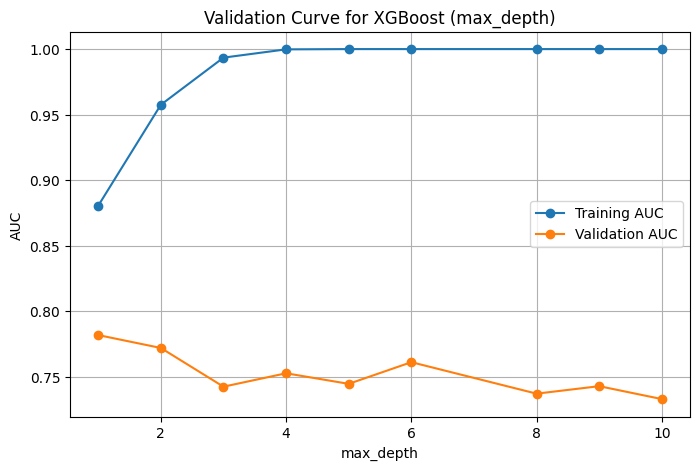

In [293]:
plt.figure(figsize=(8, 5))

plt.plot(
    df_results["max_depth"],
    df_results["train_auc"],
    marker='o',
    label="Training AUC"
)

plt.plot(
    df_results["max_depth"],
    df_results["val_auc"],
    marker='o',
    label="Validation AUC"
)

plt.xlabel("max_depth")
plt.ylabel("AUC")
plt.title("Validation Curve for XGBoost (max_depth)")
plt.legend()
plt.grid(True)
plt.show()

Hyperparameter tuning was performed by **varying the max_depth parameter** of the XGBoost model and evaluating training and validation ROC-AUC scores. The validation curve indicates

*   best-fit: max_depth=1, where the validation ROC-AUC reaches its highest value (0.7817), indicating optimal generalization performance.
*   overfitting: max_depth≥2, where training ROC-AUC continues to increase approaching 1.0 while validation ROC-AUC declines. This divergence suggests increasing model complexity leads to overfitting and reduced generalization performance.

<br>

9. Build XGBoost Model Pipeline

In [294]:
final_xgb_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        n_estimators=200,
        learning_rate=0.05,
        max_depth=1,  # optimal depth based on validation ROC-AUC
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=scale_pos_weight,
        random_state=42
    ))
])

<br>

10. Train the Model

In [295]:
final_xgb_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['age', 'credit_score',
                                                   'savings_ratio',
                                                   'loan_amount',
                                                   'debt_to_income',
                                                   'credit_utilization',
                                                   'payment_punctuality',
                                                   'income']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['location',
                                                   'business_sector',
                                                   'feedback_topic',
                                                   'sentiment'])])),
                ('model',
                 XGBClassifier(base_scor...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=1, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=200, n_jobs=None,
                               num_parallel_tree=None, ...))])

<br>

11. Make Predictions and Recommend Threshold using G-Mean

In [296]:
y_pred = final_xgb_model.predict(X_test)
y_prob = final_xgb_model.predict_proba(X_test)[:, 1]

# Compute FPR, TPR and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# You can choose the threshold closest to top-left (maximize TPR, minimize FPR)
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
best_threshold = thresholds[ix]

print(f"Recommended threshold: {best_threshold:.2f}")

y_pred_threshold = (y_prob >= best_threshold).astype(int)

Recommended threshold: 0.62


Normally, the default probability threshold is 0.5. However, this is not always optimal for imbalanced datasets.

By using the Geometric Mean (G-Mean) score, the classification threshold was optimized from the default 0.50 to 0.62 to identify the ideal separation point.

This adjustment maximizes the balance between Sensitivity (True Positive Rate) and Specificity (True Negative Rate) to ensure the model is equally effective at identifying both classes rather than being biased toward the majority class.

<br>

### **Model Evaluation**

1. Model Evaluation Metrics

In [297]:
accuracy = accuracy_score(y_test, y_pred_threshold)
f1 = f1_score(y_test, y_pred_threshold)
roc_auc = roc_auc_score(y_test, y_prob)

print(f"Model Accuracy : {accuracy:.4f}")
print(f"F1-score       : {f1:.4f}")
print(f"ROC-AUC        : {roc_auc:.4f}")

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_threshold))

Model Accuracy : 0.8633
F1-score       : 0.5287
ROC-AUC        : 0.9085

Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.87      0.92       272
           1       0.39      0.82      0.53        28

    accuracy                           0.86       300
   macro avg       0.68      0.84      0.72       300
weighted avg       0.92      0.86      0.88       300



**Remarks:**

The XGBoost model achieved an overall accuracy of 86.33% and a high ROC-AUC score of 0.9085, indicating strong predictive performance. The high ROC-AUC score indicates that the model maintains a good balance between sensitivity (recall) and specificity across different decision thresholds.

**Performance on Non-Default Class (Class 0)**

*   (Precision: 0.98, Recall: 0.87, F1-score: 0.92)

The model is highly reliable for the majority class. With a precision of 0.98, nearly all customers predicted as 'Non-Default' are correctly identified as safe borrowers. A recall of 0.87 shows that the model successfully captures 87% of all legitimate non-default cases, with a very low rate of false negatives.

**Performance on Default Class (Class 1)**

*   (Precision: 0.39, Recall: 0.82, F1-score: 0.53)

This is the most significant area of improvement. The model is now highly effective at risk detection:

- Recall (Sensitivity) is 0.82: The model successfully detects 82% of actual loan defaulters. This is a critical metric for risk management, as it means the model misses very few risky loans (low false negatives).

- Precision is 0.39: While there are some false positives (safe customers flagged as risky), this trade-off is acceptable to achieve high recall. The model is correctly identifying the majority of defaults while maintaining a reasonable precision level.

<br>

2. Confusion Matrix Visualization

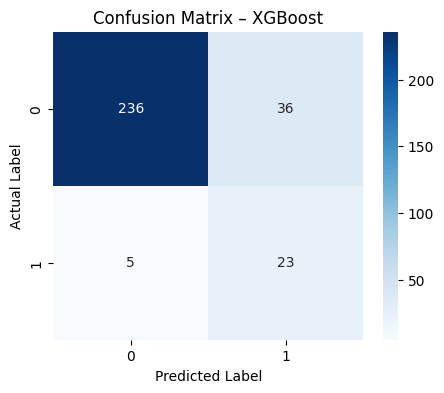

In [298]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred_threshold)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix – XGBoost")
plt.show()

The confusion matrix shows that the model correctly identifies 23 out of 28 default cases (82% recall), with only 5 missed defaulters, demonstrating effective minority-class detection despite some increase in false positives.

<br>

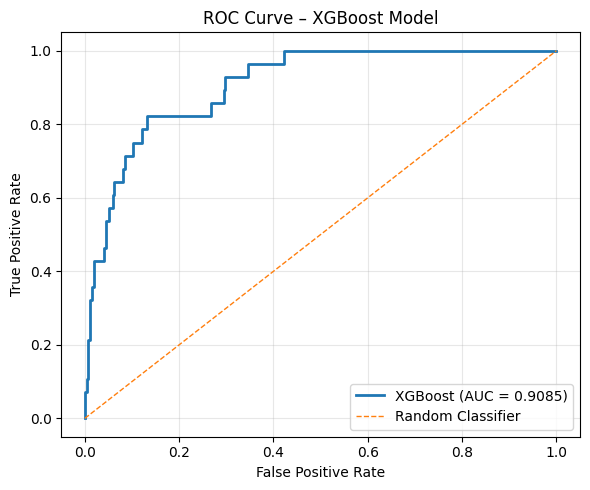

In [299]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, linewidth=2, label=f"XGBoost (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1, label="Random Classifier")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – XGBoost Model")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

The model demonstrates strong predictive performance, achieving a high Area Under the ROC Curve (AUC) of 0.9085. This indicates that the model has a 90.85% probability of ranking a randomly selected default case higher than a randomly selected non-default case, reflecting excellent class discrimination capability.

The ROC curve shows a steep initial rise, reaching a True Positive Rate of approximately 0.80 while maintaining a relatively low False Positive Rate of around 0.15. This indicates that the model is able to correctly identify most default cases while limiting the number of false alarms. Furthermore, the substantial separation between the model’s ROC curve and the random classifier baseline confirms that the model has learned meaningful and non-random patterns from the data.

<br>

### **Performance of Accuracy, F1-score and ROC-AUC Before Handling Class Imbalance**

In [300]:
# Define target
TARGET_COL = "default_history"

# Features and target (baseline)
X_baseline = df.drop(columns=[TARGET_COL])
y_baseline = df[TARGET_COL]

# Train-test split
X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(
    X_baseline,
    y_baseline,
    test_size=0.2,
    random_state=42,
    stratify=y_baseline
)

# Baseline XGBoost model (no class imbalance handling, no tuning)
xgb_baseline = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42
)

# Pipeline
baseline_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", xgb_baseline)
])

# Train model
baseline_pipeline.fit(X_train_base, y_train_base)

# Predictions
y_pred_base = baseline_pipeline.predict(X_test_base)
y_prob_base = baseline_pipeline.predict_proba(X_test_base)[:, 1]

# Evaluation
accuracy_base = accuracy_score(y_test_base, y_pred_base)
f1_base = f1_score(y_test_base, y_pred_base)
roc_auc_base = roc_auc_score(y_test_base, y_prob_base)

# Output
print(f"Baseline Accuracy : {accuracy_base:.4f}")
print(f"Baseline F1-score : {f1_base:.4f}")
print(f"Baseline ROC-AUC  : {roc_auc_base:.4f}")

print("\nBaseline Classification Report:\n")
print(classification_report(y_test_base, y_pred_base))

Baseline Accuracy : 0.9333
Baseline F1-score : 0.1667
Baseline ROC-AUC  : 0.7829

Baseline Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       282
           1       0.33      0.11      0.17        18

    accuracy                           0.93       300
   macro avg       0.64      0.55      0.57       300
weighted avg       0.91      0.93      0.92       300



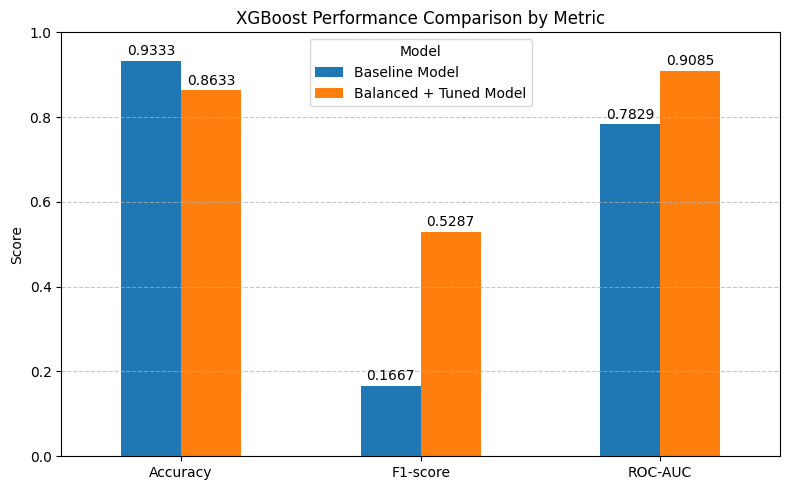

In [301]:
comparison_df = pd.DataFrame({
    "Accuracy": [0.9333, 0.8633],
    "F1-score": [0.1667, 0.5287],
    "ROC-AUC": [0.7829, 0.9085]
}, index=["Baseline Model", "Balanced + Tuned Model"])

comparison_plot = comparison_df.T  # metrics on x-axis

fig, ax = plt.subplots(figsize=(8, 5))

bars = comparison_plot.plot(
    kind="bar",
    ax=ax
)

# Add values on top of bars
for container in ax.containers:
    ax.bar_label(container, fmt="%.4f", padding=2)

ax.set_title("XGBoost Performance Comparison by Metric")
ax.set_ylabel("Score")
ax.set_ylim(0, 1)
ax.set_xticklabels(comparison_plot.index, rotation=0)
ax.grid(axis="y", linestyle="--", alpha=0.7)
ax.legend(title="Model")

plt.tight_layout()
plt.show()

Accuracy
- The baseline model achieves higher accuracy because it mainly predicts the majority class. But in imbalanced datasets, accuracy can be misleading because predicting “non-default” most of the time still yields high accuracy.

F1-score
- The baseline model struggles to detect default cases, leading to a very low F1-score. But the balanced + tuned model significantly improves precision–recall trade-off, resulting in a much higher F1-score.

ROC-AUC
- ROC-AUC measures how well the model separates default vs non-default cases across all thresholds. The balanced + tuned model shows a strong improvement, indicating better ranking and discrimination.




While the baseline model achieves higher accuracy due to majority-class dominance, the balanced and tuned model substantially improves minority-class detection, as evidenced by higher F1-score and ROC-AUC, making it more suitable for this imbalanced classification problem.

<br>

### **Class Imbalance (SMOTE)**
(Prove the reason explained before is valid)

In [302]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

xgb_smote = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("model", XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        max_depth=1,
        n_estimators=200,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    ))
])

xgb_smote.fit(X_train, y_train)

# Predictions on test set
y_pred_smote = xgb_smote.predict(X_test)
y_prob_smote = xgb_smote.predict_proba(X_test)[:, 1]
threshold = best_threshold
y_pred_threshold_smote = (y_prob_smote >= threshold).astype(int)

# Metrics
accuracy_smote = accuracy_score(y_test, y_pred_threshold_smote)
f1_smote = f1_score(y_test, y_pred_threshold_smote)
roc_auc_smote = roc_auc_score(y_test, y_prob_smote)

# Output
print(f"Model Accuracy : {accuracy_smote:.4f}")
print(f"F1-score       : {f1_smote:.4f}")
print(f"ROC-AUC        : {roc_auc_smote:.4f}")

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_threshold_smote))

Model Accuracy : 0.9067
F1-score       : 0.0000
ROC-AUC        : 0.8856

Classification Report:

              precision    recall  f1-score   support

           0       0.91      1.00      0.95       272
           1       0.00      0.00      0.00        28

    accuracy                           0.91       300
   macro avg       0.45      0.50      0.48       300
weighted avg       0.82      0.91      0.86       300



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


=== Model Comparison ===
                  Accuracy  F1-score  ROC-AUC
scale_pos_weight    0.7600    0.3898   0.9085
SMOTE               0.9067    0.0000   0.8856


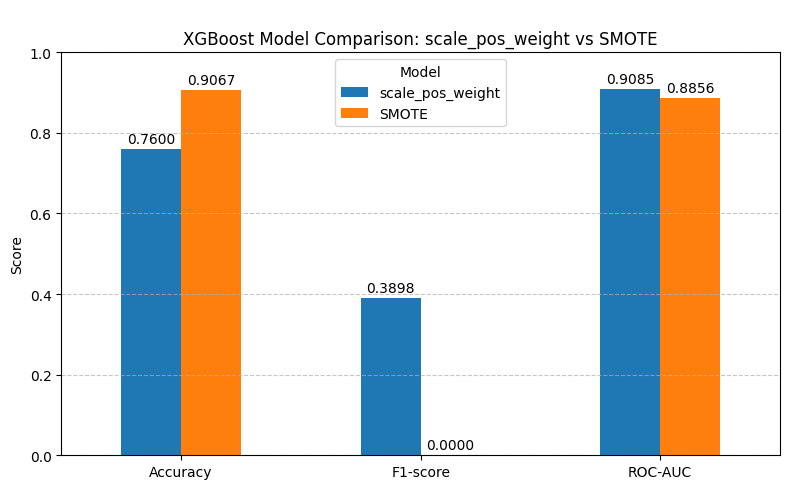

In [303]:
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# 1. Define function to get metrics
def get_metrics(y_true, y_pred, y_prob):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "F1-score": f1_score(y_true, y_pred),
        "ROC-AUC": roc_auc_score(y_true, y_prob)
    }

# 2. Compute metrics for both models

# Model 1: XGB with scale_pos_weight
metrics_model1 = get_metrics(y_test, y_pred, y_prob)

# Model 2: XGB with SMOTE
metrics_model2 = get_metrics(y_test, y_pred_smote, y_prob_smote)

# 3. Create comparison table
comparison_df = pd.DataFrame([metrics_model1, metrics_model2],
                             index=["scale_pos_weight", "SMOTE"])
comparison_df = comparison_df.round(4)

print("=== Model Comparison ===")
print(comparison_df)

# Transpose so metrics are on x-axis
comparison_plot = comparison_df.T

# Plot
fig, ax = plt.subplots(figsize=(8,5))
bars = comparison_plot.plot(kind='bar', ax=ax)

# Add values on top of each bar
for bar_group in bars.containers:
    ax.bar_label(bar_group, fmt="%.4f", label_type='edge', padding=2)

plt.title("\nXGBoost Model Comparison: scale_pos_weight vs SMOTE")
plt.ylabel("Score")
plt.ylim(0, 1)  # Metrics range between 0 and 1
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title="Model")
plt.tight_layout()
plt.show()

Although the SMOTE-based model achieved higher accuracy, it failed to identify any minority-class instances, resulting in an F1-score of zero.

While its ROC-AUC remains relatively high, indicating reasonable class separability, the fixed decision threshold led to poor minority-class prediction.

In contrast, the **scale_pos_weight** model demonstrated better minority-class detection with a substantially higher F1-score and comparable ROC-AUC, making it more suitable for this imbalanced classification task despite lower overall accuracy.

<br>

### **Feature Importance**

1. Extract Feature Names

In [304]:
xgb_clf = final_xgb_model.named_steps["model"]
importances = xgb_clf.feature_importances_

<br>

2. Get feature names after encoding

In [305]:
num_features = numerical_features

cat_features_encoded = (
    final_xgb_model.named_steps['preprocessor']
    .named_transformers_['cat']
    .get_feature_names_out(categorical_features)
)

all_features = np.concatenate([num_features, cat_features_encoded])

<br>

3. Create Feature Importance DataFrame

In [306]:
importance_df = pd.DataFrame({
    "Feature": all_features,
    "Importance": importances
})

<br>

4. Map Encoded Features Back to Original Feature Names

In [307]:
def original_feature_name(feature):
    # Numerical features stay the same
    if feature in numerical_features:
        return feature
    # One-hot encoded features → take original column name
    return feature.split("_")[0]

<br>

5. Assign Original Feature Names

In [308]:
importance_df["Features"] = importance_df["Feature"].apply(original_feature_name)

<br>

6. Aggregate Feature Importance by Original Feature

In [309]:
aggregated_importance = (
    importance_df
    .groupby("Features", as_index=False)["Importance"]
    .sum()
    .sort_values(by="Importance", ascending=False)
)

<br>

7. Display Top 10 Features

In [310]:
aggregated_importance.head(10)

,Features,Importance
2,credit_score,0.174621
1,business,0.174527
5,feedback,0.110013
10,savings_ratio,0.107681
8,location,0.094089
4,debt_to_income,0.092132
7,loan_amount,0.051985
3,credit_utilization,0.051603
9,payment_punctuality,0.049475
6,income,0.049312


<br>

8. Plot Feature Importance (Top 10)

/tmp/ipython-input-2643245519.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Features', data=aggregated_importance.head(10), palette='viridis')


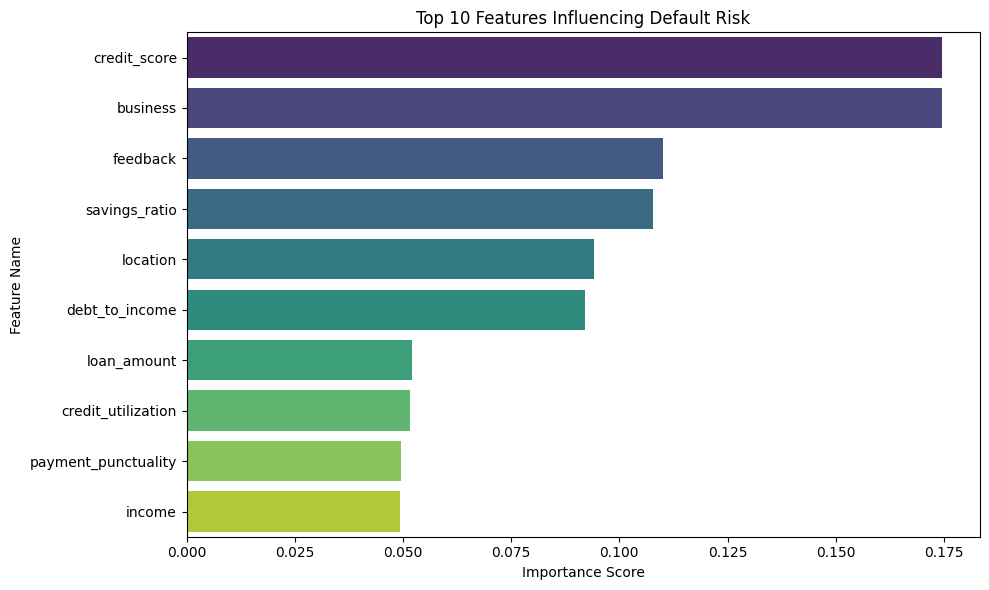

In [311]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Features', data=aggregated_importance.head(10), palette='viridis')

plt.title('Top 10 Features Influencing Default Risk')
plt.xlabel('Importance Score')
plt.ylabel('Feature Name')
plt.tight_layout()
plt.show()

**Remarks:**

The feature importance analysis indicates that credit score and business-related factors are the strongest determinants of default risk in the model. Notably, behavioral and financial stability indicators, such as customer feedback and savings ratio, exhibit greater influence than raw financial capacity measures like income. This suggests that the model places more emphasis on financial discipline, repayment behavior, and borrower profile rather than relying solely on income levels when predicting default outcomes.



